In [3]:
# data source
data_file = '/Users/jiangyi.wang/Desktop/Desktop - LAZ-SG-L-M-1109/Account Takeover/login v1.2/ato feature/ato_login_sample_feature_v1_1655893065556.txt'

# define venture, entrance (all entrance)
venture = 'ID'

# the whole dataset includes:
# 1155 black samples; 31718 white samples; (32873 in total)
# define training, testing dataset: (80%, 20% respectively)
# training: 26298 samples
# test: 6575 samples

# define whether to display feature importance, shap or PR curve on test data
is_grid_search, is_feature_importance, is_shap, is_plot_pr = True, True, True, True
# define whether to skip some sections, False means do not run that part
is_save_model, is_plot_interactive_pr, is_plot_thrhld_bin, is_comparision_w_old_model = False, True, True, True

# model feature list
features_to_use = ['no_unique_umid_14d',
                  'no_unique_ip2_14d',
                  'no_unique_ipisp_14d',
                  'id_new_umid_14d',
                  'id_new_ip2_14d',
                  'id_new_ipisp_14d',
                  'id_is_auto',
                  'id_umid_same_seller_14d',
                  'id_ip2_same_seller_14d',
                  'avg_price_per_order_14d',
                  'std_price_per_order_14d',
                  'avg_dscnt_rate_per_order_14d',
                  'std_dscnt_rate_per_order_14d',
                  'avg_shpfee_per_order_14d',
                  'std_shpfee_per_order_14d',
                  'id_susp_paymethod_14d',
                  'no_acct_umid_14d',
                  'max_cancel_rate_14d',
                  'max_avg_price_seller_14d',
                  'max_avg_dscnt_rate_seller_14d',
                  'max_avg_shpfee_seller_14d',
                  'id_susp_device'
                  ]

# used for EDA
features_type = [False,
                 False,
                 False,
                 True,
                 True,
                 True,
                 True,
                 True,
                 True,
                 False,
                 False,
                 False,
                 False,
                 False,
                 False,
                 True,
                 False,
                 False,
                 False,
                 False,
                 False,
                 True
                ]

# not used for training
byr_idx_cols = ['label', 'buyer_id']

# feature list that needs to impute
features_to_impute = ['no_unique_umid_14d',
                  'no_unique_ip2_14d',
                  'no_unique_ipisp_14d',
                  'id_new_umid_14d',
                  'id_new_ip2_14d',
                  'id_new_ipisp_14d',
                  'id_is_auto',
                  'id_umid_same_seller_14d',
                  'id_ip2_same_seller_14d',
                  'avg_price_per_order_14d',
                  'std_price_per_order_14d',
                  'avg_dscnt_rate_per_order_14d',
                  'std_dscnt_rate_per_order_14d',
                  'avg_shpfee_per_order_14d',
                  'std_shpfee_per_order_14d',
                  'id_susp_paymethod_14d',
                  'no_acct_umid_14d',
                  'max_cancel_rate_14d',
                  'max_avg_price_seller_14d',
                  'max_avg_dscnt_rate_seller_14d',
                  'max_avg_shpfee_seller_14d',
                  'id_susp_device']

# candidate of models
model_list = ['rf', 'xgb']


# params of model
rf_default_param = {'bootstrap': True, 'oob_score': True, 'max_depth':10, 'n_estimators': 120, 'criterion':'gini',
             'n_jobs': -1, 'random_state': 0
               , 'class_weight': 'balanced'
            }
rf_param_grid = {
            'max_depth': [2, 8, 16],
            'n_estimators': [64, 128, 256],
            'bootstrap': [True], 
            'oob_score': [True], 
            'criterion':['gini'],
            'random_state': [0], 
            'class_weight': ['balanced'],
            'random_state': [0]
            }    

xgb_default_param = {'verbosity':0, 'n_jobs': -1, 'random_state':0}
xgb_param_grid = {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5],
            'verbosity':[0],
            'use_label_encoder':[False],
            'random_state': [0]
            }              

model_params = {'rf': [rf_default_param, rf_param_grid],
                'xgb': [xgb_default_param, xgb_param_grid]
               }

# seed for generating the training / testing set
random_state = 42
test_size = 0.2
cv = 5
threshold_setting = 0.5

In [4]:
# best parameter achieved by Grid Search
best_estimator_rf =  {
        'bootstrap' : [True],
        'class_weight' : ['balanced'],
        'criterion' : ['gini'],
        'max_depth' : [8],
        'n_estimators' : [256],
        'oob_score' : [True],
        'random_state' : [0]
    }

best_estimator_xgb =  {
        'colsample_bytree' : [0.8],
        'gamma' : [0.5],
        'max_depth' : [3],
        'min_child_weight' : [1],
        'random_state' : [0],
        'subsample' : [1.0],
        'use_label_encoder' : [False],
        'verbosity' : [0]
    }


model_params_best = {'rf': [rf_default_param, best_estimator_rf],
                'xgb': [xgb_default_param, best_estimator_xgb]
               }

# Import

In [6]:
%pip install xgboost
%pip install shap
%pip install plotly
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import plotly.express as px

import json
import numpy as np
import pandas as pd
from datetime import datetime, timezone, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, precision_recall_curve, f1_score, roc_auc_score
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import RandomizedSearchCV
import shap

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Functions for visualisation

In [7]:
# define function to reduce data size
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df




# define function to plot PR curve
def plot_pr(y, pred):
    # based on different thresholds
    precision, recall, thresholds = precision_recall_curve(y, pred)

    f1_scores = []
    for i in range(len(thresholds)):
        f1_scores.append(2*recall[i]*precision[i]/(recall[i]+precision[i]))
    
    # select the best model according to the f1-score
    ix = np.argmax(f1_scores)
#     print('Best threshold: ', thresholds[ix])
#     print('Best F1-Score: ', np.max(f1_scores))

    fig, ax = plt.subplots()
    ax.plot(recall, precision)
    ax.scatter(recall[ix], precision[ix], marker='o', color='red', label='Best')

    # add axis labels to plot
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    plt.show()

    return thresholds[ix], precision, recall, thresholds, f1_scores


# display the distribution of features
# col2 represents the label;
# col1 reprensts the features
def display_kdeplot(df, col1, col2, is_cat):
    df[col1] = df[col1].astype(float)
    plt.figure(figsize = (15, 6))
    if is_cat:
        sns.countplot(data = df, x = col1, hue = col2)
    else:
        ax = plt.axes()
        sns.kdeplot(data = df[df[col2] == 0], x = col1, color = 'darkorange', label = 'Non-ATO')
        ax_bis = ax.twinx()
        sns.kdeplot(data = df[df[col2] == 1], x = col1, label = 'ATO')
        plt.title(col1)
        ax.legend(loc = 'upper left')
        ax_bis.legend(loc = 'upper right')
        # ax.set_xscale('log')
    plt.show
    
    print(df.groupby(col2)[col1].describe())


# Functions for training

In [9]:
# given the whole data, return the training set and testing set
def train_test_generation(df, features_to_use, byr_idx_cols, test_size, random_state):
    feature_list = byr_idx_cols + features_to_use
    # only select the features we need
    df = df[feature_list].astype(float)
    
    y = df['label']
    
    df_train, df_test, y_train, y_test = train_test_split(df, y, test_size = test_size, random_state = random_state)
    
    X_train, X_test = df_train[features_to_use], df_test[features_to_use]
    
    return X_train, y_train, X_test, y_test, df_test

# show the model performance given the ground-truth label and predicted label
def display_model_metrics(y, y_pred):
    print('     F1 score:', f1_score(y, y_pred))
    print('     AUC:', roc_auc_score(y, y_pred))
    print('     Accuracy:', accuracy_score(y, y_pred))
    print('     Precision:', precision_score(y, y_pred))
    print('     Recall:', recall_score(y, y_pred))
    print("\tConfusion matrix：\n", confusion_matrix(y, y_pred))
    
# given the model and grid-search parameter, return the best parameter
def model_grid_search(is_grid_search, clf_gs, param_grid, default_param, cv, x, y):
    if is_grid_search:
        grid_search = GridSearchCV(estimator = clf_gs,
                                  param_grid = param_grid,
                                  scoring = 'roc_auc',
                                  cv = cv,
                                  verbose = 1,
                                  n_jobs = 1
                                  )
        grid_search.fit(x, y)
        best_param = grid_search.best_params_
    else:
        best_param = default_param
        
    print('====> grid search parameters: \n{')
    [print(key,':',value) for key, value in param_grid.items()]
    print('}\n')
        
    print('====> best estimator: \n{')
    [print(key,':',value) for key, value in best_param.items()]
    print('}\n')
    
    return best_param


# given the mdoel, training and testing set, threshold (for generating confusion matrix), feature list
## return the model prediction, display confusion matrix, feature importance, shapley value and PR curve
def model_train(mod, X_train, y_train, X_test, y_test, 
                threshold, features_to_use,
                is_feature_importance, is_shap, is_plot_pr):
    
    mod.fit(X_train, y_train)
    
    # model prediction on training set
    y_train_preds = mod.predict(X_train)
    y_train_preds_prob = mod.predict_proba(X_train)
    train_preds = [1 if y_train_preds_prob[i][1] > threshold else 0 for i in range(len(y_train_preds_prob))]
    print("=============================================================")
    print(f'Train:')
    print('Label distribution:\n{}\n'.format(y_train.value_counts()))
    display_model_metrics(y_train, train_preds)
    
    # model prediction on testing set
    y_test_preds = mod.predict(X_test)
    y_test_preds_prob = mod.predict_proba(X_test)
    test_preds = [1 if y_test_preds_prob[i][1] > threshold else 0 for i in range(len(y_test_preds_prob))]
    print("\n=============================================================")
    print('Testing:')
    print('Label distribution:\n{}\n'.format(y_test.value_counts()))
    display_model_metrics(y_test, test_preds)
    
    output_list = [mod]

    
    # feature importance
    if is_feature_importance is True:
        print("=============================================================")
        print(pd.DataFrame({'feature': list(features_to_use),
               'importance': mod.feature_importances_}).\
                sort_values('importance', ascending = False))
    # shapley value
    if is_shap is True:
        print("=============================================================")
        print('SHAP explanation: \n')
        explainer = shap.TreeExplainer(mod)
        shap_values = explainer.shap_values(X_test)
        try: 
            shap.summary_plot(shap_values[1], X_test, max_display=30)
        except:
            shap.summary_plot(shap_values, X_test, max_display=30)
    # precision-recall curve
    if is_plot_pr is True:
        print("=============================================================")
        thres, precision, recall, thresholds, f1_scores = plot_pr(y_test, y_test_preds_prob[:, 1])
        output_list.append([thres, precision, recall, thresholds, f1_scores])
    
    output_list.append(y_test_preds_prob[:,1])
    
    return output_list


# Main function to cover all model training details
## Given dataset and random seed (random state), first generating training and testing set
### then use cv to achieve best parameters
#### finally use best parmaters to achieve model performance
def run_model(df, features_to_use, byr_idx_cols, cv,
              model_name, model_param, threshold, 
              is_grid_search, is_feature_importance, is_shap, is_plot_pr, test_size, random_state):
    
    X_train, y_train, X_test, y_test, df_test = train_test_generation(df, features_to_use, byr_idx_cols,
                                                                test_size, random_state)
    
    
    # model training
    x, y = X_train, y_train

    # RF
    if model_name == 'rf':
        print('=============================================================')
        print('                    Random forest model                      ')
        print('=============================================================')
        
        # grid search
        clf_gs = RandomForestClassifier()
        best_param = model_grid_search(is_grid_search, clf_gs, model_param[1], model_param[0], cv, x, y)
        clf = RandomForestClassifier(**best_param)
        
    # xgboost
    elif model_name == 'xgb':
        print('=============================================================')
        print('                      Xgboost model                          ')
        print('=============================================================')
        # grid search
        clf_gs = xgb.XGBClassifier()   
        best_param = model_grid_search(is_grid_search, clf_gs, model_param[1], model_param[0], cv, x, y)
        clf = xgb.XGBClassifier(**best_param)   
        
                
    output_list = model_train(clf, X_train, y_train, X_test, y_test, threshold,
                                  features_to_use, is_feature_importance, is_shap, is_plot_pr,
                                 )

    return output_list

# Main Part:

## 1. Load data

In [12]:
df = pd.read_csv(data_file, delimiter = ',', dtype = str)
df['label'] = df['label'].astype(float)
df.head()

,buyer_id,label,no_unique_umid_14d,no_unique_ip2_14d,no_unique_ipisp_14d,id_new_umid_14d,id_new_ip2_14d,id_new_ipisp_14d,id_is_auto,id_umid_same_seller_14d,...,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d,id_susp_device
0,10103494,0.0,1,2,1,0,0,0,1,0,...,\N,\N,\N,0,1,\N,\N,\N,\N,0
1,10129841,0.0,1,2,2,0,0,0,1,0,...,0.01721136807004846,10833.333333333334,2592.7248643506746,0,1,0.12294821560944615,119447.34551886792,0.1212258159867854,19472.91037735849,0
2,10135616,0.0,1,2,1,0,0,0,1,0,...,\N,\N,\N,0,1,\N,\N,\N,\N,0
3,10193523,0.0,1,2,2,0,0,0,1,0,...,\N,\N,\N,0,1,\N,\N,\N,\N,0
4,102859,0.0,3,4,2,0,1,0,1,0,...,0.0,1500.0,0.0,0,1,0.2865024047735398,71373.83222473579,0.08365071398793848,11939.984569672823,0


## 2. impute null values with 0

In [13]:
df = df.replace('\\N', 0)
df[features_to_impute] = df[features_to_impute].astype(float)
df.head()

,buyer_id,label,no_unique_umid_14d,no_unique_ip2_14d,no_unique_ipisp_14d,id_new_umid_14d,id_new_ip2_14d,id_new_ipisp_14d,id_is_auto,id_umid_same_seller_14d,...,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d,id_susp_device
0,10103494,0.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0
1,10129841,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,...,0.017211,10833.333333,2592.724864,0.0,1.0,0.122948,119447.345519,0.121226,19472.910377,0.0
2,10135616,0.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0
3,10193523,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0
4,102859,0.0,3.0,4.0,2.0,0.0,1.0,0.0,1.0,0.0,...,0.000000,1500.000000,0.000000,0.0,1.0,0.286502,71373.832225,0.083651,11939.984570,0.0


In [14]:
# Print the size of the dataset
print('Dataset Shape:', df.shape)
print('-------------------------------')
# Check if any columns contain null
print('Column with Nulls:')
print(df.isnull().sum()[df.isnull().sum() != 0])

Dataset Shape: (32873, 24)
-------------------------------
Column with Nulls:
Series([], dtype: int64)


## 3. Black and white samples percentage

In [15]:
# Calculate percent of black samples
bl_cnt = (df.label==1).astype(float).sum()
total = (df.label!=-1).astype(float).sum()
percent = round((bl_cnt / total)*100, 2)

print(bl_cnt, 'black samples out of a total of', total, 'samples.')
print('Black sample percent: ' +  str(percent) + '%')

1155.0 black samples out of a total of 32873.0 samples.
Black sample percent: 3.51%


In [16]:
df_feature = reduce_mem_usage(df)

Memory usage of dataframe is 6.02 MB
Memory usage after optimization is: 3.20 MB
Decreased by 46.8%


In [17]:
df_feature.head()

,buyer_id,label,no_unique_umid_14d,no_unique_ip2_14d,no_unique_ipisp_14d,id_new_umid_14d,id_new_ip2_14d,id_new_ipisp_14d,id_is_auto,id_umid_same_seller_14d,...,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d,id_susp_device
0,10103494,0.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0
1,10129841,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,...,0.017212,10833.333008,2592.724854,0.0,1.0,0.122925,119447.343750,0.121216,19472.910156,0.0
2,10135616,0.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0
3,10193523,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0
4,102859,0.0,3.0,4.0,2.0,0.0,1.0,0.0,1.0,0.0,...,0.000000,1500.000000,0.000000,0.0,1.0,0.286621,71373.835938,0.083679,11939.984375,0.0


## 4. Feature EDA

In [19]:
# check unique value count within every feature
pd.set_option('display.max_rows', 200)
df_feature[features_to_use].apply(pd.Series.nunique)

no_unique_umid_14d                  9
no_unique_ip2_14d                  13
no_unique_ipisp_14d                 8
id_new_umid_14d                     2
id_new_ip2_14d                      2
id_new_ipisp_14d                    2
id_is_auto                          2
id_umid_same_seller_14d             2
id_ip2_same_seller_14d              2
avg_price_per_order_14d          4256
std_price_per_order_14d          3011
avg_dscnt_rate_per_order_14d     2211
std_dscnt_rate_per_order_14d     1952
avg_shpfee_per_order_14d         1820
std_shpfee_per_order_14d         1921
id_susp_paymethod_14d               2
no_acct_umid_14d                   80
max_cancel_rate_14d              1952
max_avg_price_seller_14d         4369
max_avg_dscnt_rate_seller_14d    1893
max_avg_shpfee_seller_14d        4369
id_susp_device                      2
dtype: int64

         count      mean       std  min  25%  50%  75%  max
label                                                      
0.0    31718.0  1.114099  0.416275  0.0  1.0  1.0  1.0  8.0
1.0     1155.0  1.093506  0.430530  0.0  1.0  1.0  1.0  5.0
------------------------------------------------------------------------
         count      mean       std  min  25%  50%  75%   max
label                                                       
0.0    31718.0  2.698625  1.393667  0.0  2.0  2.0  3.0  12.0
1.0     1155.0  2.665801  1.477444  0.0  2.0  2.0  4.0   9.0
------------------------------------------------------------------------
         count      mean       std  min  25%  50%  75%  max
label                                                      
0.0    31718.0  1.533577  0.735116  0.0  1.0  1.0  2.0  7.0
1.0     1155.0  1.627706  0.782119  0.0  1.0  2.0  2.0  5.0
------------------------------------------------------------------------
         count      mean       std  min  25%  50%  75%  m

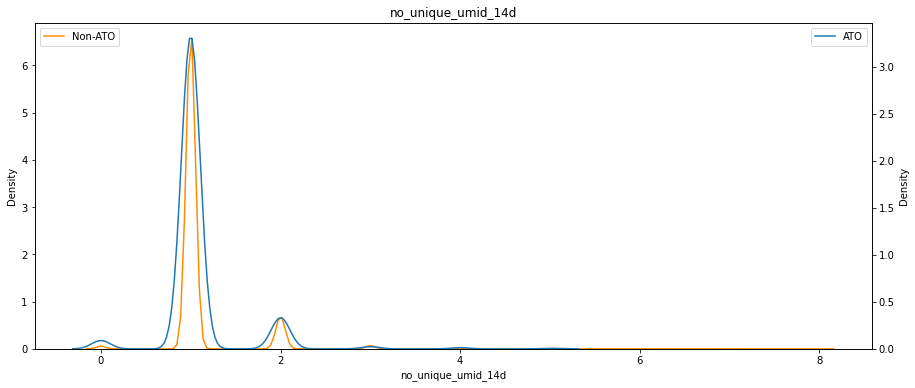

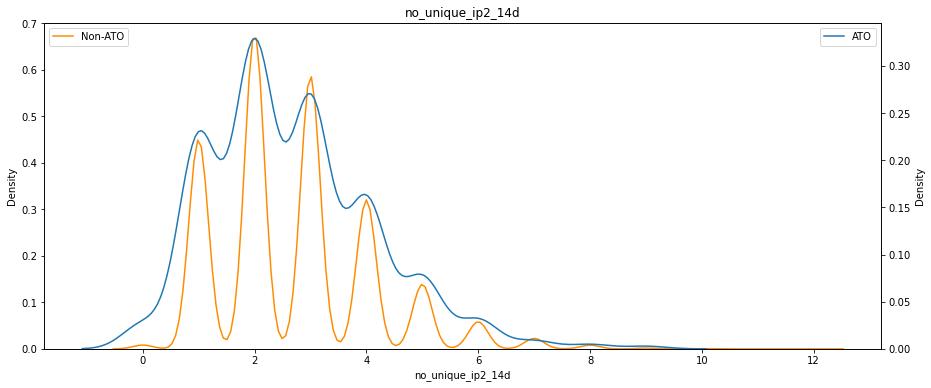

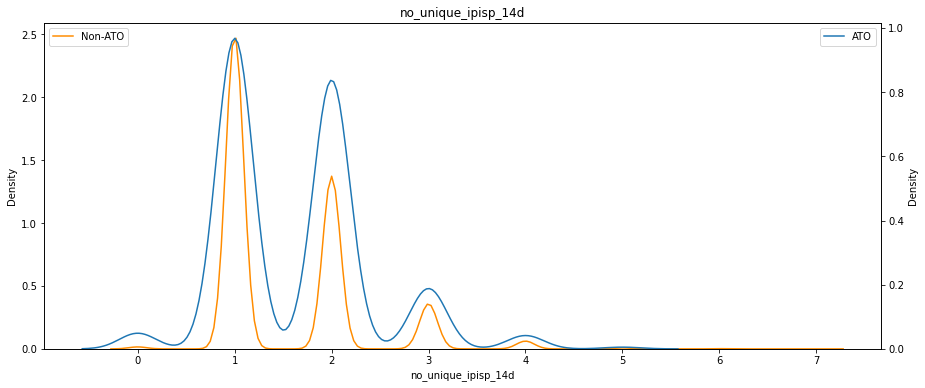

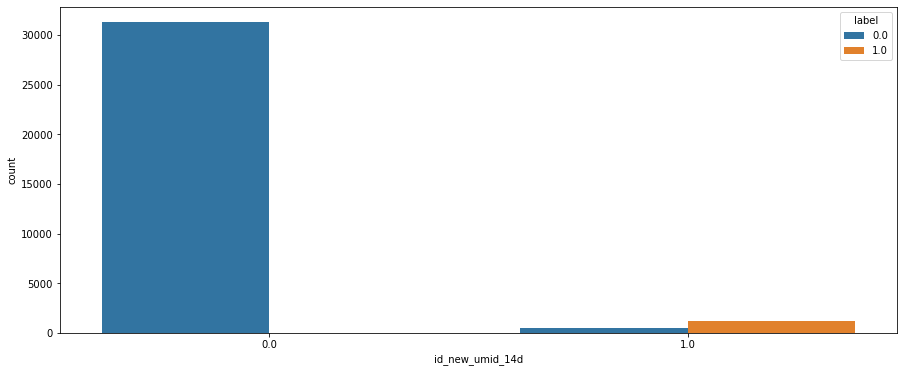

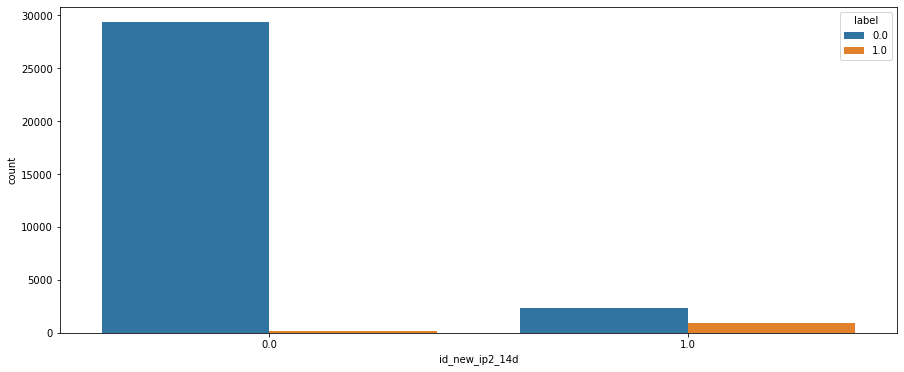

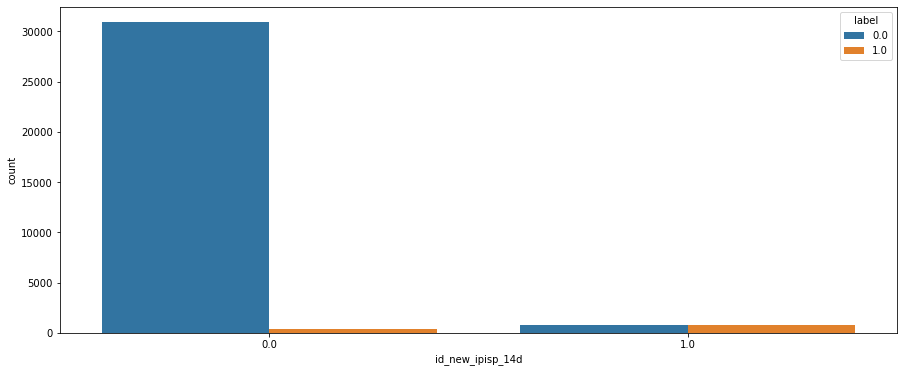

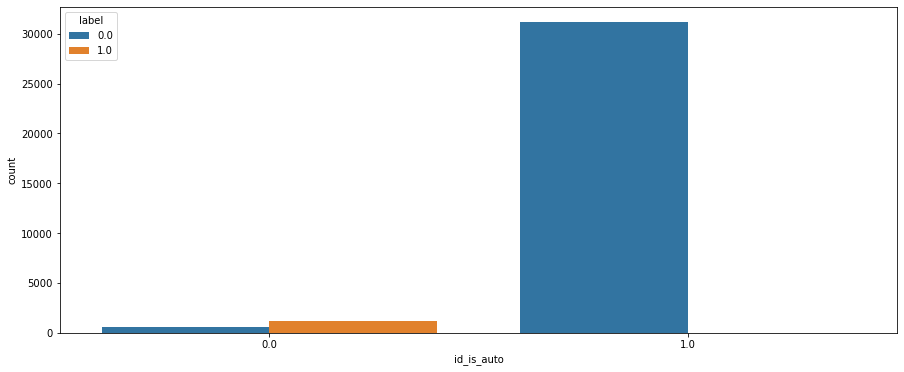

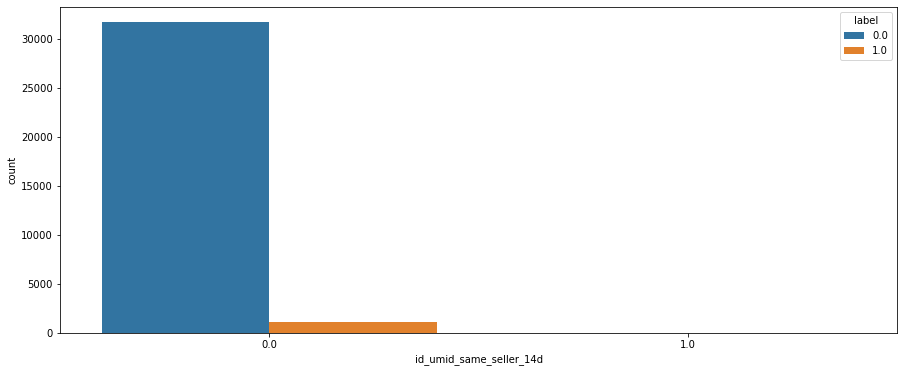

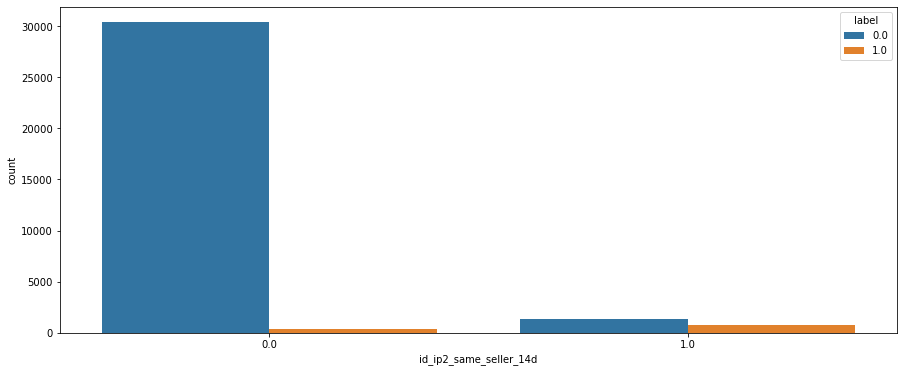

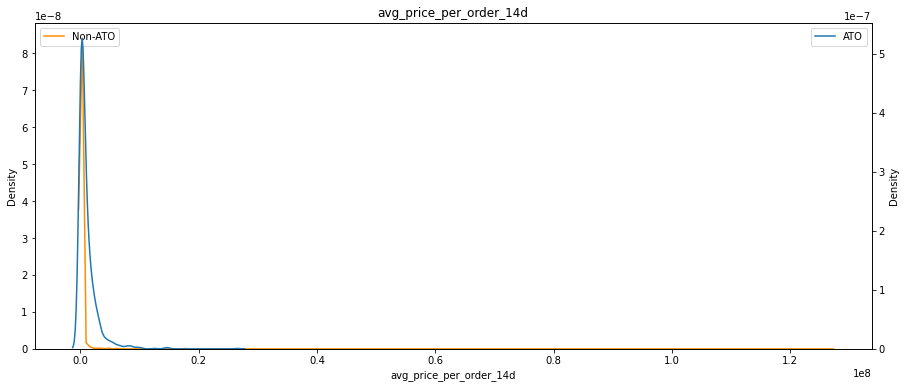

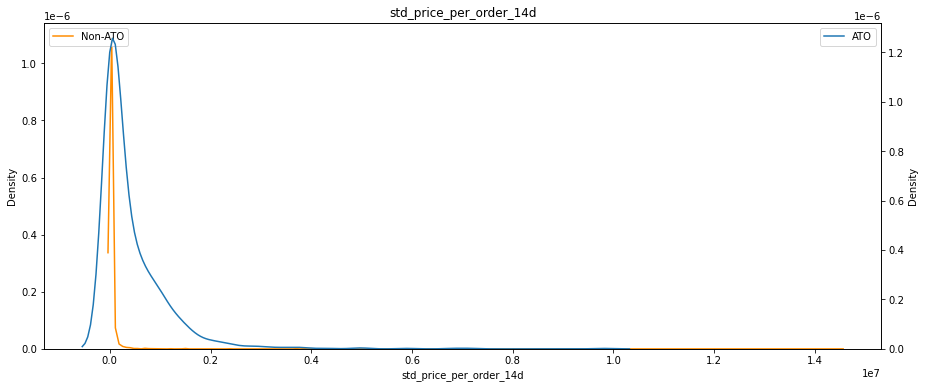

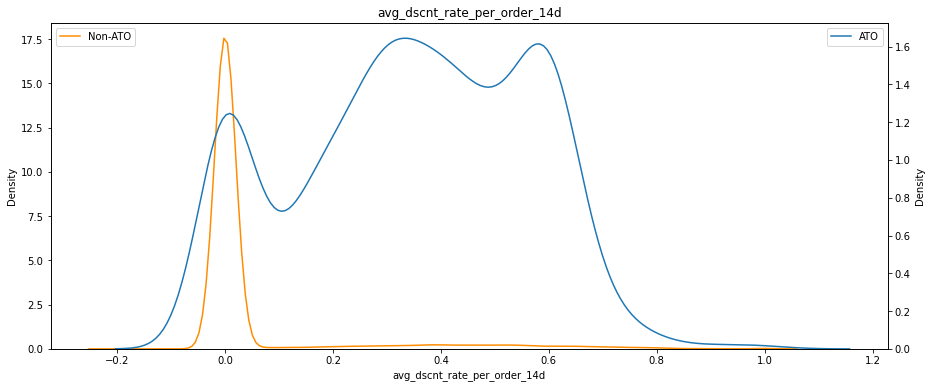

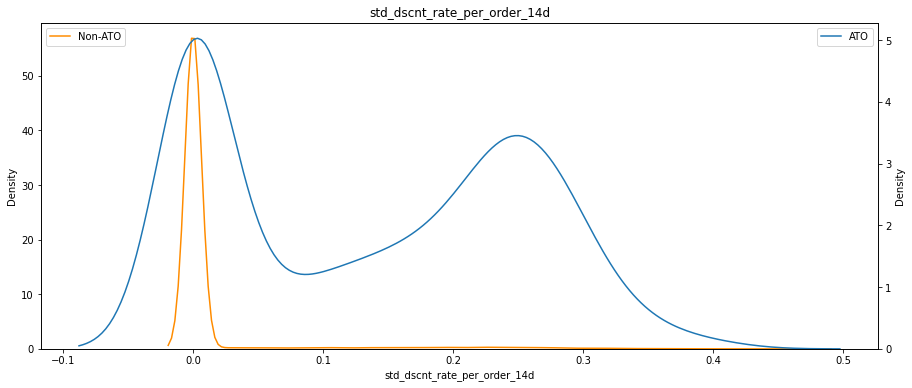

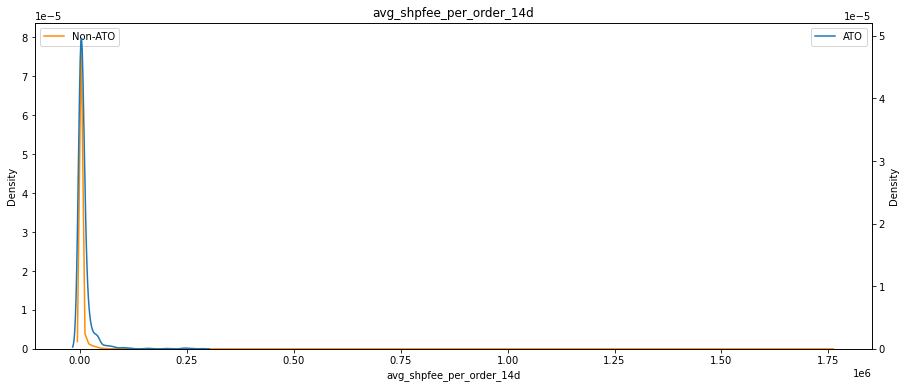

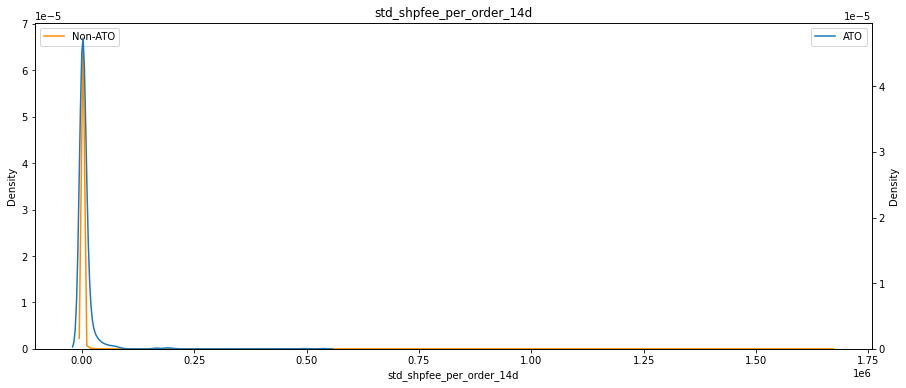

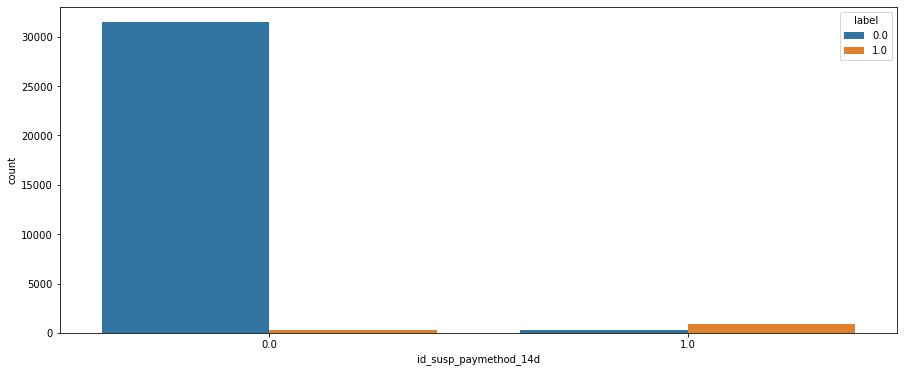

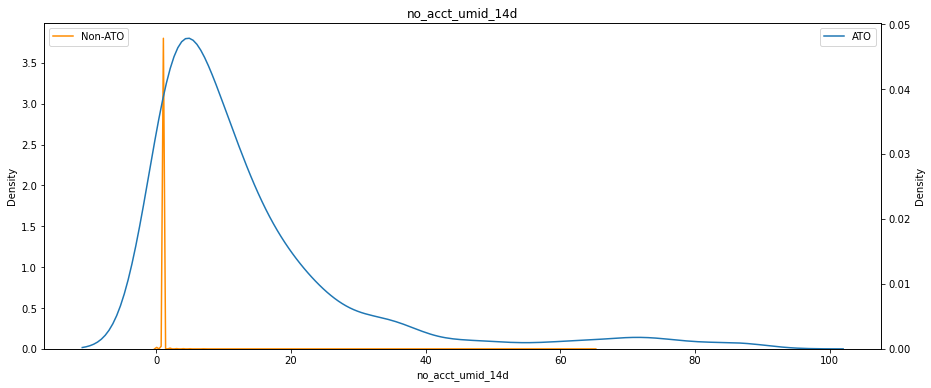

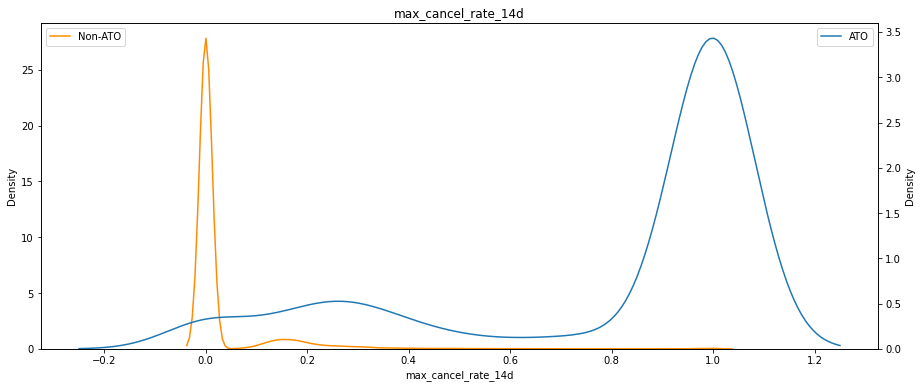

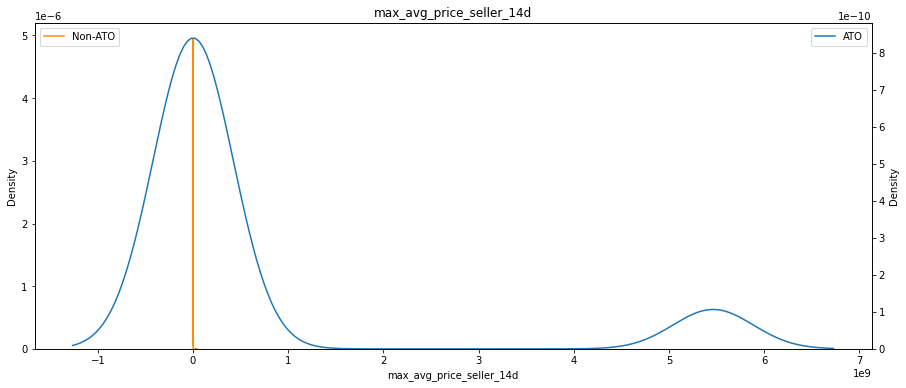

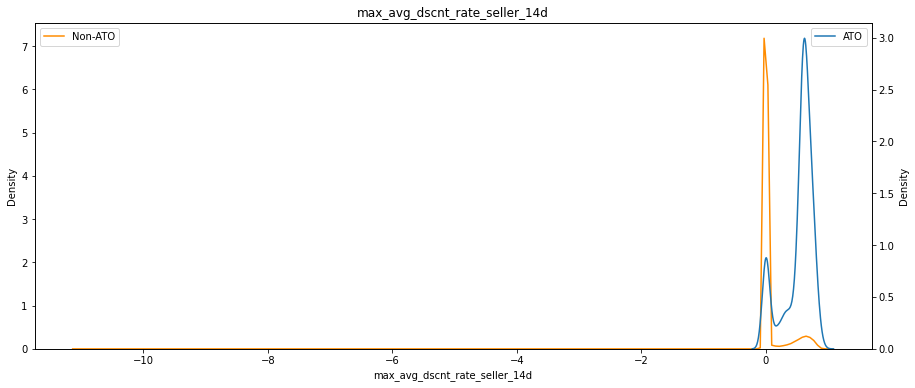

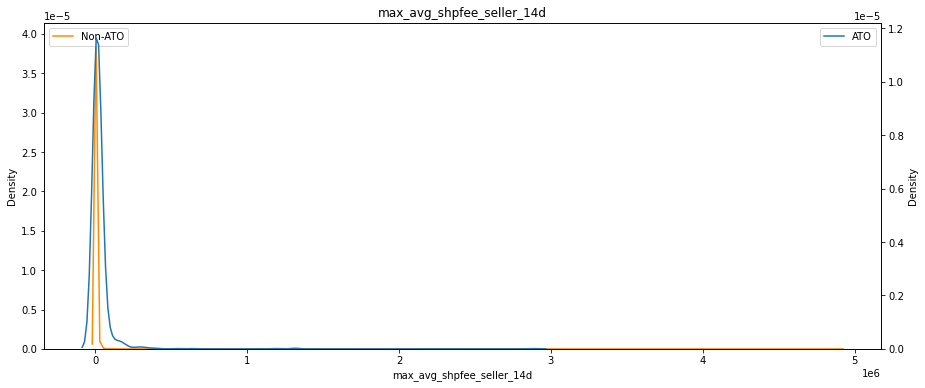

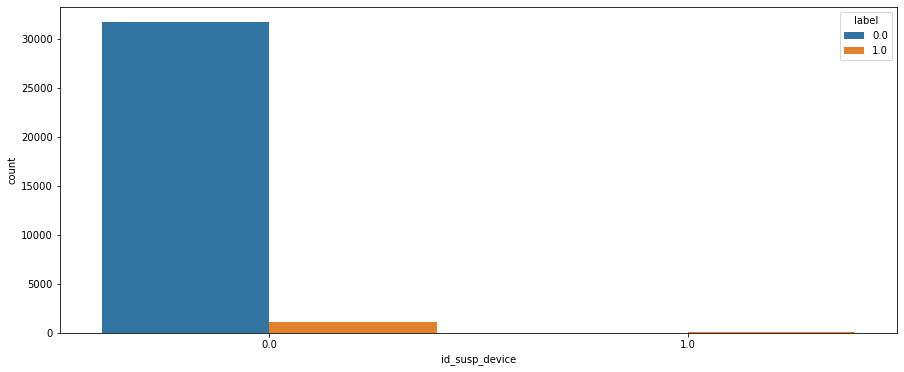

In [20]:
for i in range(len(features_to_use)):
    feature_name = features_to_use[i]
    feature_type = features_type[i]
    display_kdeplot(df_feature, feature_name, 'label', feature_type)
    print('------------------------------------------------------------------------')

                    Random forest model                      
Fitting 5 folds for each of 9 candidates, totalling 45 fits
====> grid search parameters: 
{
max_depth : [2, 8, 16]
n_estimators : [64, 128, 256]
bootstrap : [True]
oob_score : [True]
criterion : ['gini']
random_state : [0]
class_weight : ['balanced']
}

====> best estimator: 
{
bootstrap : True
class_weight : balanced
criterion : gini
max_depth : 8
n_estimators : 256
oob_score : True
random_state : 0
}

Train:
Label distribution:
0.0    25361
1.0      937
Name: label, dtype: int64

     F1 score: 0.9570990806945863
     AUC: 0.998343913883522
     Accuracy: 0.9968058407483459
     Precision: 0.9177277179236043
     Recall: 1.0
	Confusion matrix：
 [[25277    84]
 [    0   937]]

Testing:
Label distribution:
0.0    6357
1.0     218
Name: label, dtype: int64

     F1 score: 0.9582417582417583
     AUC: 0.998505584395155
     Accuracy: 0.9971102661596958
     Precision: 0.919831223628692
     Recall: 1.0
	Confusion matrix：
 [[6

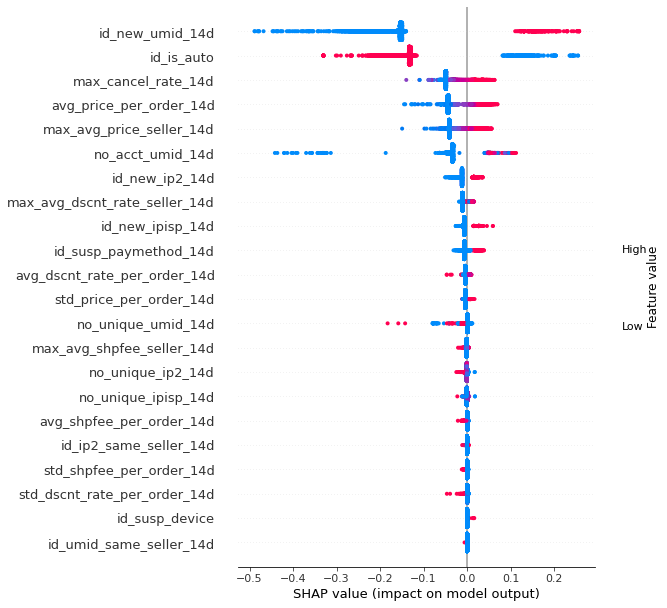

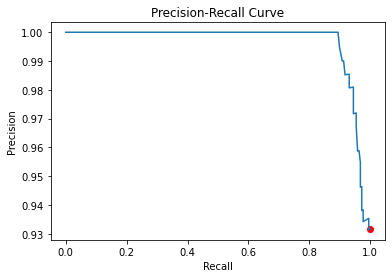

                      Xgboost model                          
Fitting 5 folds for each of 405 candidates, totalling 2025 fits
====> grid search parameters: 
{
min_child_weight : [1, 5, 10]
gamma : [0.5, 1, 1.5, 2, 5]
subsample : [0.6, 0.8, 1.0]
colsample_bytree : [0.6, 0.8, 1.0]
max_depth : [3, 4, 5]
verbosity : [0]
use_label_encoder : [False]
random_state : [0]
}

====> best estimator: 
{
colsample_bytree : 0.8
gamma : 0.5
max_depth : 3
min_child_weight : 1
random_state : 0
subsample : 1.0
use_label_encoder : False
verbosity : 0
}

Train:
Label distribution:
0.0    25361
1.0      937
Name: label, dtype: int64

     F1 score: 0.9870967741935484
     AUC: 0.9897626827837617
     Accuracy: 0.999087383070956
     Precision: 0.9945828819068255
     Recall: 0.9797225186766275
	Confusion matrix：
 [[25356     5]
 [   19   918]]

Testing:
Label distribution:
0.0    6357
1.0     218
Name: label, dtype: int64

     F1 score: 0.9724770642201835
     AUC: 0.9857666113927722
     Accuracy: 0.998174

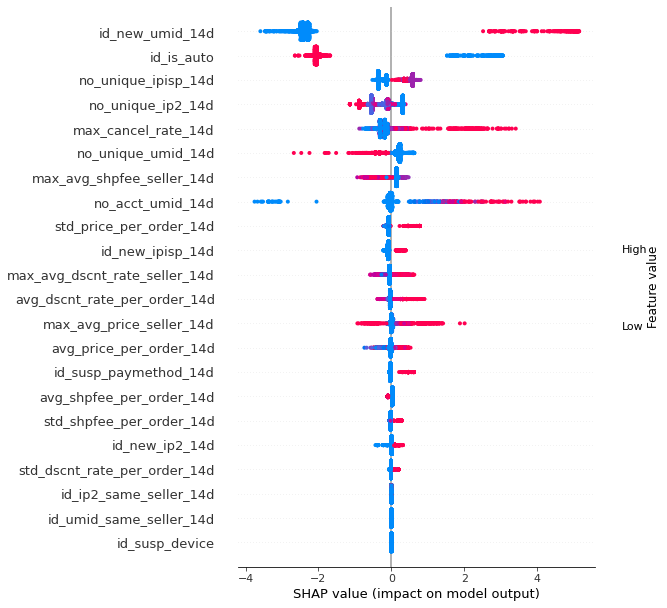

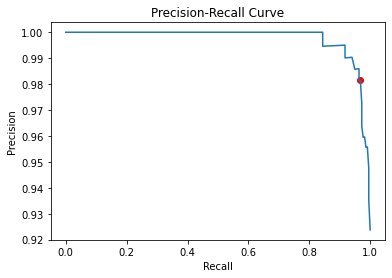

In [71]:
# Run models
res = {}
X_train, y_train, X_test, y_test, df_test = train_test_generation(df_feature, features_to_use, byr_idx_cols,
                                 test_size, random_state)
df_test['buyer_id'] = df_test['buyer_id'].astype(str)


for model in model_list:
    res_m = run_model(df_feature, features_to_use, byr_idx_cols,
                     model, model_params[model], thrshold_setting, 
                     is_grid_search, is_feature_importance, is_shap, is_plot_pr, test_size, random_state)
    res[model] = res_m
    # res_m[-2] -> parameters for PR-curve (metric and corresponding threshold)
    # res_m[-1] -> probability prediction for testing sample
    df_test[model+'_pred'] = res_m[-1]

                    Random forest model                      
Fitting 5 folds for each of 1 candidates, totalling 5 fits
====> grid search parameters: 
{
bootstrap : [True]
class_weight : ['balanced']
criterion : ['gini']
max_depth : [8]
n_estimators : [256]
oob_score : [True]
random_state : [0]
}

====> best estimator: 
{
bootstrap : True
class_weight : balanced
criterion : gini
max_depth : 8
n_estimators : 256
oob_score : True
random_state : 0
}

Train:
Label distribution:
0.0    25361
1.0      937
Name: label, dtype: int64

     F1 score: 0.9570990806945863
     AUC: 0.998343913883522
     Accuracy: 0.9968058407483459
     Precision: 0.9177277179236043
     Recall: 1.0
	Confusion matrix：
 [[25277    84]
 [    0   937]]

Testing:
Label distribution:
0.0    6357
1.0     218
Name: label, dtype: int64

     F1 score: 0.9582417582417583
     AUC: 0.998505584395155
     Accuracy: 0.9971102661596958
     Precision: 0.919831223628692
     Recall: 1.0
	Confusion matrix：
 [[6338   19]
 [   0 

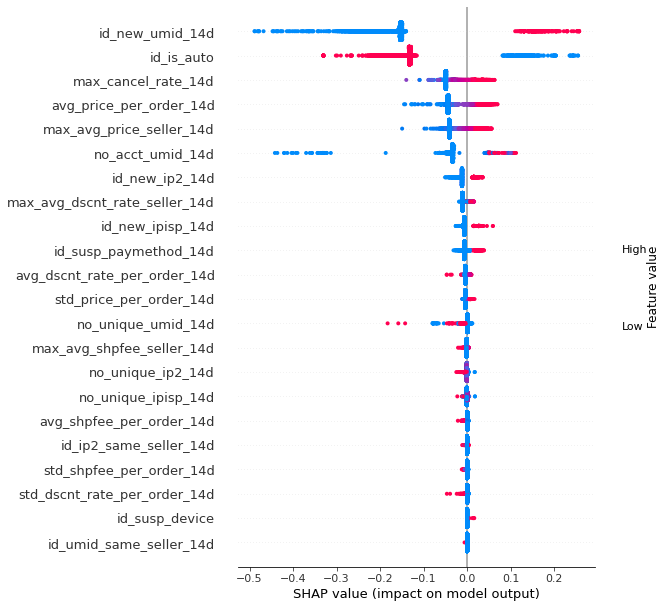

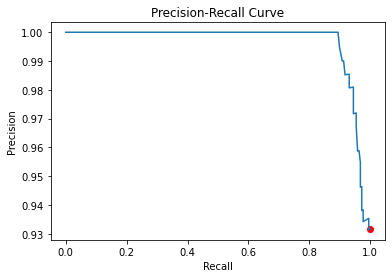

                      Xgboost model                          
Fitting 5 folds for each of 1 candidates, totalling 5 fits
====> grid search parameters: 
{
colsample_bytree : [0.8]
gamma : [0.5]
max_depth : [3]
min_child_weight : [1]
random_state : [0]
subsample : [1.0]
use_label_encoder : [False]
verbosity : [0]
}

====> best estimator: 
{
colsample_bytree : 0.8
gamma : 0.5
max_depth : 3
min_child_weight : 1
random_state : 0
subsample : 1.0
use_label_encoder : False
verbosity : 0
}

Train:
Label distribution:
0.0    25361
1.0      937
Name: label, dtype: int64

     F1 score: 0.9870967741935484
     AUC: 0.9897626827837617
     Accuracy: 0.999087383070956
     Precision: 0.9945828819068255
     Recall: 0.9797225186766275
	Confusion matrix：
 [[25356     5]
 [   19   918]]

Testing:
Label distribution:
0.0    6357
1.0     218
Name: label, dtype: int64

     F1 score: 0.9724770642201835
     AUC: 0.9857666113927722
     Accuracy: 0.9981749049429658
     Precision: 0.9724770642201835
     R

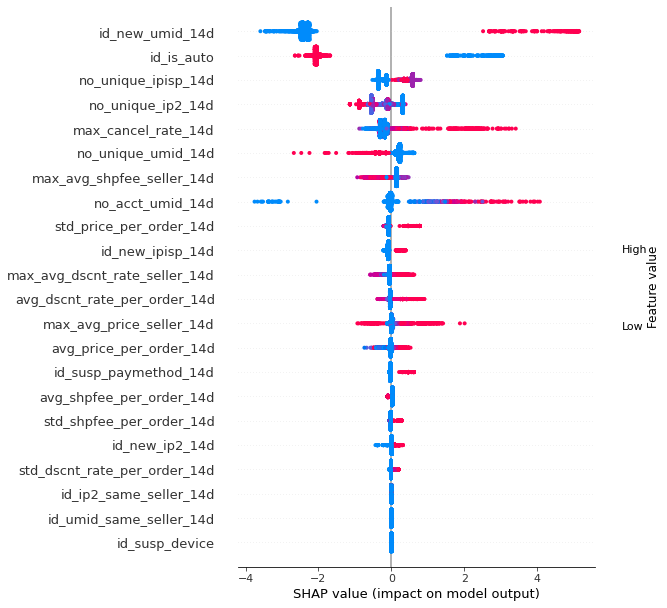

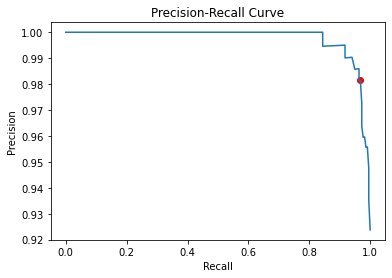

In [94]:
# Best model
res = {}

X_train, y_train, X_test, y_test, df_test = train_test_generation(df_feature, features_to_use, byr_idx_cols,
                                 test_size = test_size, random_state = random_state)
df_test = df_test.astype(float)
df_test['buyer_id'] = df_test['buyer_id'].astype(str)


for model in model_list:
    res_m = run_model(df_feature, features_to_use, byr_idx_cols, cv,
                     model, model_params_best[model], threshold_setting, 
                     is_grid_search, is_feature_importance, is_shap, is_plot_pr, test_size, random_state)
    res[model] = res_m
    # res_m[-2] -> parameters for PR-curve (metric and corresponding threshold)
    # res_m[-1] -> probability prediction for testing sample
    df_test[model+'_pred'] = res_m[-1]

## 5. Best parameter according to AOC/AUC

In [95]:
res['xgb'][-2][0]

0.5912895

## 6. Testing result Analysis

In [96]:
df_test = df_test.astype(float)
df_test['buyer_id'] = df_test['buyer_id'].astype(str)
df_test['rf_pred_label'] = df_test['rf_pred'].apply(lambda x: 1 if x > 0.5 else 0)
df_test['xgb_pred_label'] = df_test['xgb_pred'].apply(lambda x: 1 if x > 0.5 else 0)

In [97]:
pd.set_option('display.max_columns', None)
FP = df_test[(df_test['label'] == 1) & (df_test['xgb_pred_label'] == 0)]
FP

,label,buyer_id,no_unique_umid_14d,no_unique_ip2_14d,no_unique_ipisp_14d,id_new_umid_14d,id_new_ip2_14d,id_new_ipisp_14d,id_is_auto,id_umid_same_seller_14d,id_ip2_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d,id_susp_device,rf_pred,xgb_pred,rf_pred_label,xgb_pred_label
32396,1.0,400026274134.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.779876,0.344025,1,0
32344,1.0,20728592.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.796223,0.077002,1,0
32548,1.0,400129650954.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.808370,0.256060,1,0
32661,1.0,400224075641.0,1.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.744555,0.281621,1,0
32303,1.0,6979400.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.831746,0.319009,1,0
32031,1.0,400149858267.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.913391,0.377747,1,0


In [98]:
FN = df_test[(df_test['label'] == 0) & (df_test['xgb_pred_label'] == 1)]
FN

,label,buyer_id,no_unique_umid_14d,no_unique_ip2_14d,no_unique_ipisp_14d,id_new_umid_14d,id_new_ip2_14d,id_new_ipisp_14d,id_is_auto,id_umid_same_seller_14d,id_ip2_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d,id_susp_device,rf_pred,xgb_pred,rf_pred_label,xgb_pred_label
9162,0.0,410439993883.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.0,0.000000,0.000000,0.000000,0.000000,0.0,0.902086,0.511004,1,1
3394,0.0,400218519461.0,1.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,51974.500000,43025.500000,0.487793,0.084351,11000.000000,2500.000000,0.0,2.0,0.180298,75686.984375,0.562012,16621.812500,0.0,0.771386,0.949725,1,1
9645,0.0,410457510268.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,3.0,0.000000,0.000000,0.000000,0.000000,0.0,0.899641,0.511004,1,1
17738,0.0,400372413546.0,1.0,3.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.839742,0.595963,1,1
1131,0.0,400079697273.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.0,0.000000,0.000000,0.000000,0.000000,0.0,0.908345,0.799425,1,1
11537,0.0,400080456867.0,1.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,108796.570312,49234.289062,0.295410,0.241333,6920.285645,5218.217773,0.0,2.0,0.203857,38188.851562,0.581543,8407.692383,0.0,0.777988,0.988533,1,1


In [99]:
TP = df_test[(df_test['label'] == 1) & (df_test['xgb_pred_label'] == 1)]
TP

,label,buyer_id,no_unique_umid_14d,no_unique_ip2_14d,no_unique_ipisp_14d,id_new_umid_14d,id_new_ip2_14d,id_new_ipisp_14d,id_is_auto,id_umid_same_seller_14d,id_ip2_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d,id_susp_device,rf_pred,xgb_pred,rf_pred_label,xgb_pred_label
32800,1.0,400639161936.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,8.771250e+05,8.551250e+05,0.742676,0.074097,4000.000000,4000.000000,1.0,20.0,1.000000,1.732250e+06,0.712402,17280.730469,0.0,0.999690,0.999713,1,1
32134,1.0,400274706041.0,1.0,5.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,7.916354e+05,9.986358e+05,0.360596,0.358887,60371.429688,162236.187500,1.0,13.0,1.000000,3.500000e+06,0.801270,639500.000000,0.0,0.999802,0.999902,1,1
32302,1.0,6963790.0,1.0,3.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.206720e+06,0.000000e+00,0.600098,0.000000,0.000000,0.000000,1.0,1.0,1.000000,2.641680e+06,0.600098,0.000000,0.0,0.998932,0.999853,1,1
31918,1.0,400070553815.0,1.0,5.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,7.194816e+04,3.375373e+04,0.296387,0.186157,5666.666504,5467.073242,1.0,24.0,0.271973,5.463937e+09,0.620117,18483.685547,0.0,0.944319,0.994892,1,1
32376,1.0,400017958058.0,1.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,6.431710e+05,6.078290e+05,0.582520,0.182007,9250.000000,9250.000000,1.0,20.0,1.000000,2.218188e+06,0.717285,14858.392578,0.0,0.995048,0.999925,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32165,1.0,400314741940.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,86.0,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.977906,0.987929,1,1
32294,1.0,4522279.0,1.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.400000e+06,0.000000e+00,0.300049,0.000000,72000.000000,0.000000,1.0,1.0,1.000000,2.924329e+06,0.300049,58700.000000,0.0,0.971713,0.996987,1,1
32356,1.0,25638872.0,1.0,5.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,2.041000e+05,1.194913e+05,0.421143,0.076904,10166.666992,2392.116699,0.0,15.0,0.469238,7.726777e+04,0.698730,11816.278320,0.0,0.961330,0.985430,1,1
32763,1.0,400363353416.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,2.209130e+05,9.097000e+03,0.571289,0.086548,7450.000000,550.000000,0.0,22.0,0.627441,1.000395e+05,0.752930,10216.322266,1.0,0.987000,0.999136,1,1


In [100]:
df_test.head(10)

,label,buyer_id,no_unique_umid_14d,no_unique_ip2_14d,no_unique_ipisp_14d,id_new_umid_14d,id_new_ip2_14d,id_new_ipisp_14d,id_is_auto,id_umid_same_seller_14d,id_ip2_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d,id_susp_device,rf_pred,xgb_pred,rf_pred_label,xgb_pred_label
13638,0.0,400210008989.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,17000.000,0.000000,0.433350,0.000000,8000.000000,0.000000,0.0,1.0,0.150146,1.420346e+04,0.329590,10037.851562,0.0,0.000203,0.000006,0,0
3710,0.0,400232400866.0,1.0,5.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000512,0.000014,0,0
32800,1.0,400639161936.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,877125.000,855125.000000,0.742676,0.074097,4000.000000,4000.000000,1.0,20.0,1.000000,1.732250e+06,0.712402,17280.730469,0.0,0.999690,0.999713,1,1
28154,0.0,400362228341.0,1.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000481,0.000009,0,0
10217,0.0,410476974128.0,1.0,4.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000576,0.000030,0,0
13885,0.0,400220688197.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000481,0.000009,0,0
6291,0.0,400336761081.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,37360.875,33203.347656,0.248291,0.204712,42937.500000,6366.108887,0.0,1.0,0.912109,1.081551e+05,0.666992,29908.166016,0.0,0.000638,0.000026,0,0
6847,0.0,400358325463.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000576,0.000035,0,0
32134,1.0,400274706041.0,1.0,5.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,791635.375,998635.750000,0.360596,0.358887,60371.429688,162236.187500,1.0,13.0,1.000000,3.500000e+06,0.801270,639500.000000,0.0,0.999802,0.999902,1,1
30513,0.0,410439945230.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000999,0.000030,0,0


## 7. prediction part (500,000 data)

In [102]:
real_file = '/Users/jiangyi.wang/Desktop/Desktop - LAZ-SG-L-M-1109/Account Takeover/login v1.2/ato feature/ato_login_prediction_feature_v1_1656055432442.txt'

features_need = features_to_use + ['buyer_id']

# loading data
df_real = pd.read_csv(real_file, delimiter = ',', dtype = str)
df_real = df_real[features_need]
# impute null value with 0
df_real = df_real.replace('\\N', 0)
# change data type
df_real[features_to_impute] = df_real[features_to_impute].astype(float)
df_real['buyer_id'] = df_real['buyer_id'].astype(str)
df_real.head()

,no_unique_umid_14d,no_unique_ip2_14d,no_unique_ipisp_14d,id_new_umid_14d,id_new_ip2_14d,id_new_ipisp_14d,id_is_auto,id_umid_same_seller_14d,id_ip2_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d,id_susp_device,buyer_id
0,1.0,4.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,150632.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.441012,345937.020453,0.000000,0.000000,0.0,10003448
1,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,1000749
2,1.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,10007735
3,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,10009703
4,1.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,50568.0,0.0,0.754524,0.0,5712.0,0.0,1.0,1.0,0.117500,15031.564632,0.680433,8517.493541,0.0,10014904


### feed prediction data to model with best parameter

In [104]:
X_real = df_real[features_to_use]
clf_gs = xgb.XGBClassifier() 
model_param = model_params_best['xgb']
best_param = model_grid_search(is_grid_search, clf_gs, model_param[1], model_param[0], 5, X_train, y_train)
clf = xgb.XGBClassifier(**best_param)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
====> grid search parameters: 
{
colsample_bytree : [0.8]
gamma : [0.5]
max_depth : [3]
min_child_weight : [1]
random_state : [0]
subsample : [1.0]
use_label_encoder : [False]
verbosity : [0]
}

====> best estimator: 
{
colsample_bytree : 0.8
gamma : 0.5
max_depth : 3
min_child_weight : 1
random_state : 0
subsample : 1.0
use_label_encoder : False
verbosity : 0
}



XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [105]:
y_real_preds_prob = clf.predict_proba(X_real)

### use threshold 0.9

In [106]:
threshold_real = 0.9
real_preds = [1 if y_real_preds_prob[i][1] > threshold_real else 0 for i in range(len(y_real_preds_prob))]

df_real['xgb_pred'] = y_real_preds_prob[:,1]
df_real['xgb_pred_label'] = real_preds

In [107]:
df_real[(df_real['xgb_pred_label']==1) & (df_real['no_acct_umid_14d'] > 20)]

,no_unique_umid_14d,no_unique_ip2_14d,no_unique_ipisp_14d,id_new_umid_14d,id_new_ip2_14d,id_new_ipisp_14d,id_is_auto,id_umid_same_seller_14d,id_ip2_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d,id_susp_device,buyer_id,xgb_pred,xgb_pred_label
30685,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,51.0,0.000000,0.000000,0.000000,0.000000,0.0,400095246517,0.971116,1
110810,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,30.0,0.000000,0.000000,0.000000,0.000000,0.0,400632921913,0.971116,1
122403,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1476.0,0.000000,0.000000,0.000000,0.000000,0.0,400691505328,0.971116,1
122411,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1483.0,0.000000,0.000000,0.000000,0.000000,0.0,400691559308,0.971116,1
122416,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,636.0,0.000000,0.000000,0.000000,0.000000,0.0,400691595522,0.971116,1
122421,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,442.0,0.000000,0.000000,0.000000,0.000000,0.0,400691643967,0.971116,1
122456,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,972.0,0.000000,0.000000,0.000000,0.000000,0.0,400691862597,0.971116,1
155160,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,41.0,0.000000,0.000000,0.000000,0.000000,0.0,400094112917,0.971116,1
155374,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,48.0,0.000000,0.000000,0.000000,0.000000,0.0,400094793843,0.971116,1
155419,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,49.0,0.000000,0.000000,0.000000,0.000000,0.0,400094976556,0.971116,1


In [37]:
df_real[(df_real['xgb_pred_label']==1) & (df_real['no_acct_umid_14d'] <= 20)]

,no_unique_umid_14d,no_unique_ip2_14d,no_unique_ipisp_14d,id_new_umid_14d,id_new_ip2_14d,id_new_ipisp_14d,id_is_auto,id_umid_same_seller_14d,id_ip2_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d,id_susp_device,buyer_id,xgb_pred,xgb_pred_label
969,1.0,5.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.220874e+05,120663.021430,0.483425,0.221042,40687.500000,44313.469665,1.0,1.0,0.334715,3.046790e+05,0.741013,111998.241955,0.0,13182873,0.982515,1
3233,1.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,3.832000e+04,0.000000,0.781629,0.000000,0.000000,0.000000,0.0,2.0,0.206635,2.196401e+04,0.703755,7986.572187,0.0,20401625,0.937405,1
5817,1.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,9.079988e+04,52585.066560,0.205583,0.228598,6487.500000,4121.722183,0.0,1.0,0.831325,1.625280e+05,0.721796,43744.534031,0.0,32162838,0.951091,1
22275,2.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.255180e+05,90918.601485,0.324308,0.208444,0.000000,0.000000,0.0,2.0,0.338983,1.942923e+05,0.504030,22100.482213,0.0,400064433626,0.915708,1
29850,1.0,5.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.450000e+06,0.000000,0.000000,0.000000,25000.000000,0.000000,0.0,1.0,0.903226,1.485161e+06,0.003661,176298.245614,0.0,400092177595,0.905844,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450200,1.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,3.200000e+04,0.000000,0.786667,0.000000,0.000000,0.000000,0.0,2.0,0.192505,3.413698e+04,0.780896,24725.033003,0.0,400252680519,0.938312,1
455357,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,18.0,0.000000,0.000000e+00,0.000000,0.000000,0.0,400270755026,0.948259,1
462699,1.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,8.176400e+04,73519.118822,0.470948,0.114006,13095.666667,6539.502572,0.0,1.0,0.220641,1.434675e+05,0.676401,25566.401163,0.0,400296681186,0.938923,1
472091,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,5.866750e+04,29770.323625,0.442560,0.118559,12125.000000,3542.156829,0.0,2.0,0.229327,6.199620e+04,0.530912,20072.588698,0.0,400332597409,0.941810,1


# 8. Export the model

In [108]:
%pip install sklearn2pmml
%pip install nyoka
%pip install pypmml
from sklearn2pmml import PMMLPipeline
from sklearn2pmml import sklearn2pmml
from nyoka import xgboost_to_pmml 
from sklearn.pipeline import Pipeline
from pypmml import Model

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [109]:
params = {
        'booster' : 'gbtree',
        'colsample_bytree' : 0.8,
        'gamma' : 0.5,
        'max_depth' : 3,
        'min_child_weight' : 1,
        'random_state' : 0,
        'subsample' : 1.0,
        'use_label_encoder' : False,
        'verbosity' : 0,
        'n_jobs' : -1,
        'random_state': 0
}

In [110]:
clf_xgb = xgb.XGBClassifier(**params)

In [111]:
clf_pipeline = Pipeline([('xgb', clf_xgb)])

In [112]:
clf_pipeline.fit(X_train, y_train)
y_pred = clf_pipeline.predict(X_test)
y_pred_probability = clf_pipeline.predict_proba(X_test)
y_pred_probability[0:10]

array([[9.9999380e-01, 6.1878650e-06],
       [9.9998635e-01, 1.3643753e-05],
       [2.8675795e-04, 9.9971324e-01],
       [9.9999130e-01, 8.6930422e-06],
       [9.9997032e-01, 2.9703890e-05],
       [9.9999130e-01, 8.6930422e-06],
       [9.9997383e-01, 2.6176907e-05],
       [9.9996448e-01, 3.5494595e-05],
       [9.8228455e-05, 9.9990177e-01],
       [9.9996954e-01, 3.0437430e-05]], dtype=float32)

### check if the two training results agree

In [113]:
df_test

,label,buyer_id,no_unique_umid_14d,no_unique_ip2_14d,no_unique_ipisp_14d,id_new_umid_14d,id_new_ip2_14d,id_new_ipisp_14d,id_is_auto,id_umid_same_seller_14d,id_ip2_same_seller_14d,avg_price_per_order_14d,std_price_per_order_14d,avg_dscnt_rate_per_order_14d,std_dscnt_rate_per_order_14d,avg_shpfee_per_order_14d,std_shpfee_per_order_14d,id_susp_paymethod_14d,no_acct_umid_14d,max_cancel_rate_14d,max_avg_price_seller_14d,max_avg_dscnt_rate_seller_14d,max_avg_shpfee_seller_14d,id_susp_device,rf_pred,xgb_pred,rf_pred_label,xgb_pred_label
13638,0.0,400210008989.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,17000.000000,0.000000,0.433350,0.000000,8000.000000,0.000000,0.0,1.0,0.150146,1.420346e+04,0.329590,10037.851562,0.0,0.000203,0.000006,0,0
3710,0.0,400232400866.0,1.0,5.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000512,0.000014,0,0
32800,1.0,400639161936.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,877125.000000,855125.000000,0.742676,0.074097,4000.000000,4000.000000,1.0,20.0,1.000000,1.732250e+06,0.712402,17280.730469,0.0,0.999690,0.999713,1,1
28154,0.0,400362228341.0,1.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000481,0.000009,0,0
10217,0.0,410476974128.0,1.0,4.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000576,0.000030,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11791,0.0,400098744791.0,2.0,5.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000913,0.000014,0,0
10925,0.0,400030656510.0,1.0,5.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000512,0.000011,0,0
21786,0.0,400047603464.0,2.0,7.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000323,0.000005,0,0
22545,0.0,400104363805.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,133157.328125,74496.328125,0.385254,0.225464,2360.333252,2428.178223,0.0,1.0,0.194336,8.333334e+04,0.663086,9000.000000,0.0,0.001986,0.000031,0,0


In [114]:
target = 'label'
xgboost_to_pmml(clf_pipeline, features_to_use, target, "/Users/jiangyi.wang/Desktop/Desktop - LAZ-SG-L-M-1109/Account Takeover/login v1.2/model/ATO_login_v1.2.pmml")

In [117]:
model = Model.fromFile("/Users/jiangyi.wang/Desktop/Desktop - LAZ-SG-L-M-1109/Account Takeover/login v1.2/model/ATO_login_v1.2.pmml")
model.predict(X_test)

Py4JError: An error occurred while calling o39520.iterator. Trace:
java.lang.reflect.InaccessibleObjectException: Unable to make public final java.util.Iterator java.util.HashMap$KeySet.iterator() accessible: module java.base does not "opens java.util" to unnamed module @1796cf6c
	at java.base/java.lang.reflect.AccessibleObject.checkCanSetAccessible(AccessibleObject.java:354)
	at java.base/java.lang.reflect.AccessibleObject.checkCanSetAccessible(AccessibleObject.java:297)
	at java.base/java.lang.reflect.Method.checkCanSetAccessible(Method.java:199)
	at java.base/java.lang.reflect.Method.setAccessible(Method.java:193)
	at py4j.reflection.MethodInvoker$1.run(MethodInvoker.java:240)
	at java.base/java.security.AccessController.doPrivileged(AccessController.java:318)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:238)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:833)

